In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from copy import deepcopy
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

In [2]:
df = pd.read_csv('Dataset/IntrusionDetection/data.csv')
training = df.sample(frac=0.8, random_state=200)
training = training.iloc[:, :-1]
validation = df.drop(training.index)

In [3]:
def covariance_matrix(data):
    n = len(list(data.columns.values)[:-1])
    sum_mat = np.zeros(shape=(n, n))
    prod = None

    columns = list(data.columns.values)[:-1]

    for col in columns:
        m = data[col].mean()
        data[col] -= m

    for index, row in data.iterrows():
        a = np.array(row.values[:-1])
        X = np.mat(row.values[:-1])
        XT = X.T
        prod = XT.dot(X)
        sum_mat = sum_mat.__add__(prod)

    m = len(data['service'])

    cov = sum_mat/m
    
    return cov

In [4]:
def get_k(s):
    den = sum(s)
    num = 0
    for k in range(0, 29):
        num += s[k]
        retained = num/den
        if retained >= 0.90:
            break
    return k+1

In [5]:
def pca(data):
    
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    scaled = (data-mean)/std
    cov = np.cov(scaled.T)
    
    U, S, V = np.linalg.svd(cov)
    
    k = get_k(S)
    
    reduced_matrix = U[:, :k]
    
    z = ((reduced_matrix.T).dot(data.T)).T
    
    return z, reduced_matrix
    
z, red_mat = pca(training)

In [6]:
def stats(method, clusters, data, k):
    print('\nStats for ', method)
    avg = 0.0
    total = 0.0
    label = df.iloc[:, -1]
    for c in range(k):
        cluster = []
        for i in range(len(data)):
            if clusters[i] == c:
                cluster.append(label[i])
        cluster_label, num_of_occurences = Counter(cluster).most_common(1)[0]
        purity = float(num_of_occurences)/len(cluster)
        print('Cluster - ' + str(c) + '(' + str(cluster_label) + ') has purity: ' + str(purity))
        total += purity
    avg = total/5.0
    return avg

In [7]:
def kmeans(data):
    k = 5
    n = len(data)
    c = []
    for i in range(k):
        c.append(data[np.random.randint(0, len(data))])
    clusters = np.zeros(n)
    
    distances = np.zeros((n, k))
    centroids = np.array(c, dtype = np.float32)
    centroids_old = np.zeros(shape=(5,14))
    centroids_new = deepcopy(centroids)
    
    error = np.linalg.norm(centroids_new - centroids_old)
    
    while error != 0:
        
        for i in range(k):
            distances[:,i] = np.linalg.norm(data-centroids[i], axis=1)
            
        clusters = np.argmin(distances, axis=1)
        
        centroids_old = deepcopy(centroids_new)
        
        for i in range(k):
            centroids_new[i] = np.mean(data[clusters == i], axis=0)
        
        error = np.linalg.norm(centroids_new - centroids_old)
        
    return stats('K-Means', clusters, data, k)
    
avg_km = kmeans(red_mat)


Stats for  K-Means
Cluster - 0(normal) has purity: 0.6666666666666666
Cluster - 1(normal) has purity: 0.6
Cluster - 2(normal) has purity: 1.0
Cluster - 3(normal) has purity: 0.5
Cluster - 4(normal) has purity: 0.6666666666666666


In [8]:
gmm = GaussianMixture(n_components=5)
clusters = gmm.fit_predict(red_mat)
avg_gmm = stats('GMM', clusters, red_mat, 5)


Stats for  GMM
Cluster - 0(normal) has purity: 0.7083333333333334
Cluster - 1(dos) has purity: 1.0
Cluster - 2(normal) has purity: 1.0
Cluster - 3(normal) has purity: 0.5
Cluster - 4(probe) has purity: 1.0


In [9]:
hierarchical = AgglomerativeClustering(n_clusters=5, linkage='single')
clusters = hierarchical.fit_predict(red_mat)
avg_hc = stats('Hierarchical Clustering', clusters, red_mat, 5)


Stats for  Hierarchical Clustering
Cluster - 0(normal) has purity: 0.64
Cluster - 1(probe) has purity: 1.0
Cluster - 2(normal) has purity: 1.0
Cluster - 3(normal) has purity: 1.0
Cluster - 4(normal) has purity: 1.0


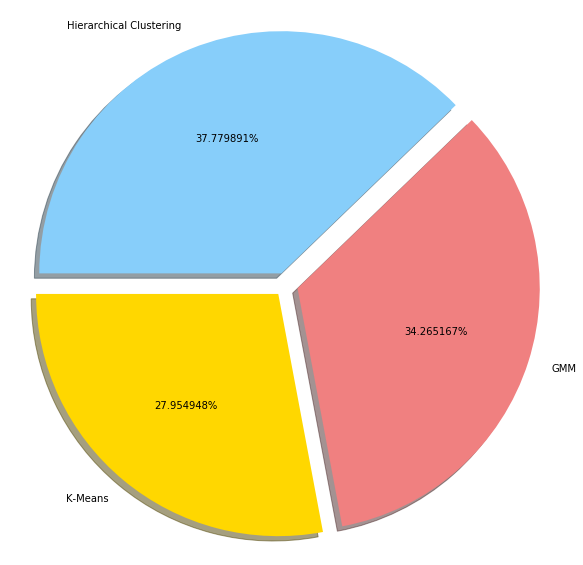

In [10]:
labels = 'K-Means', 'GMM', 'Hierarchical Clustering'
sizes = [avg_km ,avg_gmm, avg_hc]
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0.05, 0.05, 0.05)
 
plt.figure(figsize=(10,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%f%%', shadow=True, startangle=180)
 
plt.axis('equal')
plt.show()